# How to replicate the European Commission DSA

This notebook features an tutorial for the stochastic DSA model replication introduced in "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). For details on the methodology see the methodology section below and Annex A3 of the [European Commission's Debt Sustainability Monitor 2023](https://economy-finance.ec.europa.eu/publications/debt-sustainability-monitor-2023_en).

For comments and suggestions please contact lennard.welslau[at]gmail[dot]com.\
Last update: 01 June 2024

## Methodology

### Deterministic Debt Projections

The starting point for the DSA methodology applied in this paper is the European Commission’s Debt Sustainability Monitor (DSM) 2023 (European Commission, 2024). Annex A3 of the DSM describes debt dynamics and the projection of implicit interest rate on government debt. The debt ratio in a given year, $d_t$, is calculated as:

$$
d_t = \alpha^n \cdot d_{t-1} \cdot \frac{(1+\text{iir}_t)}{(1+g_t)} + \alpha^f \cdot d_{t-1} \cdot \frac{(1+\text{iir}_t)}{(1+g_t)} \cdot \frac{e_t}{e_{t-1}} - pb_t + f_t, 
$$

where:
- $\alpha^n$ represents the share of total government debt denominated in domestic currency,
- $\alpha^f$ represents the share of total government debt denominated in other currencies,
- $\text{iir}_t$ represents the implicit interest rate on government debt (total interest payment during a year divided by the stock of debt at the end of the previous year),
- $g_t$ represents the nominal growth rate of GDP (in national currency),
- $e_t$ represents the nominal exchange rate (expressed as national currency per foreign currency),
- $pb_t$ represents the primary balance ratio,
- $f_t$ represents stock-flow adjustments over GDP.

#### Adverse Deterministic Stress Tests

In addition to the baseline deterministic scenario, three alternative deterministic scenarios, or stress tests, are also calculated by the Commission:

- **‘Lower SPB’ scenario**: the SPB is assumed to be reduced by 0.5 pp. of GDP in total, with a reduction of 0.25 pp. each year over the first two years, and to remain at that level afterwards (apart from changes in the cost of ageing – see below).
- **‘Adverse r-g’ scenario**: the interest/growth-rate differential is assumed to be permanently increased by 1 percentage point.
- **‘Financial stress’ scenario**: market interest rates are assumed to temporarily increase for one year by 1 pp., plus a risk premium for high-debt countries.

These adverse scenarios are assumed for ten years after the end of the adjustment period. The DSA criterion requires the public debt to GDP ratio to decline under these adverse scenarios.

#### Data Sources

- Shares of euro-denominated debt are calculated based on ECB data.
- Exchange rates are taken from Eurostat. Both variables are assumed to remain constant over the projection horizon.
- Stock-flow adjustments are taken from the AMECO database and based on projections by the European Commission’s DG ECFIN, available up to 2025. From 2026, stock-flow adjustments are assumed to be zero for all but three EU countries (Finland, Luxembourg, and Greece, see [DSM 2023 Section II.2](https://economy-finance.ec.europa.eu/publications/debt-sustainability-monitor-2023_en) for details).
- Nominal GDP growth, the primary balance, and the implicit interest rate on government debt are endogenous model variables. They build on medium-term real growth, output gap, and GDP-deflator projections by the European Commission’s Output Gap Working Group, long-term growth and ageing-cost projections based on the European Commission’s 2024 Ageing report, long-term market expectations for inflation from Bloomberg, structural primary balance projections from the AMECO database, fiscal multiplier data based on Carnot and de Castro (2015), and budget balance semi-elasticities based on Mourre et al. (2019).

The projection of the implicit interest rate on government debt further relies on ECB data on government debt stocks, shares of short- and long-term debt issuance, and average annual debt redemption, as well as market expectations for interest rates from Bloomberg. All data sources are described in detail in the [SOURCES.xlsx](..\data\SOURCES.xlsx) file found in the data folder of the accompanying GitHub repository.

#### Projecting Nominal Growth

The effect of fiscal stimulus and the cyclical dependence of the budget balance makes growth and primary balance projections mutually dependent. These dependencies affect the variables from the beginning of the adjustment period in 2025. Prior to the adjustment period, i.e. up to 2024, the model relies directly on projections for the primary balance and nominal growth taken from the AMECO database. From 2025, real growth is affected by annual adjustments of the structural primary balance. Specifically, in a given year, the effect of the fiscal multiplier effect is proportional to annual adjustments in the structural primary balance relative to its baseline trajectory:

$$ 
m_t = 0.75 \times (\Delta \text{spb}_t - \Delta \text{spb}_t^{BL}) 
$$

Here, 0.75 is the fiscal multiplier of Carnot and de Castro (2015) and $\Delta \text{spb}_t^{BL}$ denotes the annual change in baseline structural primary balance, which is based on the DG ECFIN projections up to 2024 and held constant thereafter. The multiplier $m_t$ affects real growth via its persistent effect on the output gap, narrowing the output gap by $m_t$ in the year of the adjustment $t$, and reducing its impact by one-third of its initial effect in the two consecutive periods. Thus, the total impact on the output gap in a particular year is the sum of the impact in that year plus 2/3 of the impact from the previous year plus 1/3 of the impact from two years before.

For euro area countries, Bulgaria, Czechia, Denmark, and Sweden, inflation numbers used to compute nominal growth rates are based on the European Commission’s forecast up to 2025 (GDP deflator), which are linearly interpolated with market expectations for 2033 implied by euro area inflation swaps (HICP), before converging to the 2 percent HICP inflation targets of these countries by 2053, in line with the Commission’s methodology. For Hungary, Poland, and Romania, where the central banks have higher than 2 percent inflation target, the Commission’s methodology assumes that half of the spread vis-à-vis euro area inflation expected in 2025 remains by 2033, which in turn gradually converges to the national inflation targets by 2053.

#### Projecting the Primary Balance

The primary balance ratio is the sum of the structural primary balance ratio, a cyclical component, a property income component, and an ageing cost component. Importantly, the latter component, ageing costs net of pension tax revenues, is not separated out during the adjustment period. After the end of the adjustment period, it is assumed that the structural primary balance without the change in ageing costs remains the same, thus, the change in ageing costs changes the structural primary balance after the end of the adjustment period. Ageing costs and pension tax revenues are based on the European Commission’s 2024 Ageing report. The cyclical component is defined as the product of country-specific budget balance elasticities and the output gap.

#### Projecting the Implicit (Average) Interest Rate

The implicit (average) interest rate on the public debt stock, $\text{iir}_t$, is projected as the weighted average of the short-term market interest rate $i_t^{ST}$ and the long-term implicit interest rate $\text{iir}_t^{LT}$:

$$ 
\text{iir}_t = \alpha_{t-1} \cdot i_t^{ST} + (1 - \alpha_{t-1}) \cdot \text{iir}_t^{LT} 
$$

Here, $\alpha_{t-1}$ is the share of short-term debt in the total debt stock in $t-1$ and $\text{iir}_t^{LT}$ is projected as the weighted average of the long-term market rate $i_t^{LT}$ and the long-term implicit market interest rate in $t-1$:

$$ 
\text{iir}_t^{LT} = \beta_{t-1} \cdot i_t^{LT} + (1 - \beta_{t-1}) \cdot \text{iir}_{t-1}^{LT} 
$$

where $\beta_{t-1}$ is the share of new long-term debt issuance in total long-term debt stock in $t-1$. Long-term market rates are projected by linearly interpolating from Bloomberg 10-year government bond benchmark rates to 10Y10Y forward rates. Between T+10 and T+30, long-term market rates converge linearly to 2 percent plus national inflation targets, which yields 4.5 percent for Poland and Romania, 5 percent for Hungary, and 4 percent for all other countries. Short-term market rates are calculated using 3 months benchmark rates, 3M10Y forward rates, and 0.5 times the country-specific values for the long-term rate in T+30.

To project the implicit interest rate forward, we calculate the new issuance and total stock of short-term and long-term debt in each period $t$. Gross financing needs, i.e. the size of new issuance, are the sum of all interest and amortization payments, and the primary balance. Here, interest on short-term debt is the product of short-term market rates and the stock of short-term debt in $t-1$. Interest on long-term debt is the product

## Tutorial
This section introduces some of the functionalities of the DsaModel class and the StochasticDsaModel class.

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from classes import *
from functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

### Initializing the DSA model and projecting the debt ratio

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "DsaModel" can be used, although I recommend always calling the StochasticDsaModel class to have access to all functionalities.

In [17]:
bel_dsa4 = DsaModel(country='BEL', adjustment_period=4)

Model functions (methods) and variables (attributes) can be inspected by typing the class name, followed by the attribute name. \
Explore the DsaModelClass and the StochasticDsaModelClass python files to see which attributes and methods exist.

In [18]:
bel_dsa4.ageing_cost

array([25.11216836, 25.35902661, 25.30438211, 25.42929057, 25.60866998,
       25.72537935, 25.86872455, 25.80469106, 25.93176262, 26.01668618,
       26.10791039, 26.1841957 , 26.30936245, 26.40669419, 26.52080311,
       26.594857  , 26.68438292, 26.72071055, 26.80365452, 26.84497823,
       26.94859525, 27.02029991, 27.15116563, 27.23184868, 27.36570423,
       27.44523852, 27.56918723, 27.64303992, 27.75526931, 27.82627099,
       27.94471488, 28.02307079, 28.14872417, 28.22890923, 28.35022875,
       28.41932622, 28.52620324, 28.58020844, 28.6788269 , 28.73220022,
       28.83952431, 28.90131935, 29.01595248, 29.08404081, 29.21529306,
       29.30357521, 29.44872925, 29.5572773 ])

We can project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [19]:
bel_dsa4.project(spb_target=1.6, scenario='financial_stress')

For non-linear adjustment paths, for example due to an Excessive Deficit Procedure, we can specify each ajdustment step individually via the "adjustment_steps" attribute. \
Instead of specifying the steps manually, we can also call the "find_edp" method, which finds the number of periods in which, given the current SPB target, the minimum adjustment of 0.5% under the EDP is binding. The resulting minimum adjustment steps are updated automatically and saved in the "edp_steps" attribute. In cases where the entire adjustment period is needed to reach the 3% deficit targets, the adjustment step size is increased.

In [22]:
adjustment_steps = np.array([0.5, 0.5, 0.5, 0])
bel_dsa4.project(adjustment_steps=adjustment_steps,
                scenario='main_adjustment')
bel_dsa4.adjustment_steps

array([0.5, 0.5, 0.5, 0. ])

We can show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe. If the method is called without specified variables, it returns a dataframe with the structural primary balance, the overall balance, and the debt ratio. 

In [23]:
bel_dsa4.df().iloc[1:7]

,,d,ob,sb,spb_bca,spb_bca_adjustment
t,y,,,,,
1,2024,104.804,-4.263,-4.023,-1.869,0.309
2,2025,106.303,-4.273,-3.631,-1.369,0.500
3,2026,106.532,-3.912,-3.253,-0.869,0.500
4,2027,106.311,-3.448,-2.850,-0.369,0.500
5,2028,105.340,-3.151,-2.921,-0.369,0.000
6,2029,104.837,-3.212,-3.135,-0.369,0.000


If the df method is called with parameter "all" set to "True", a preset list of variables will be included. The included variables are listed below.

In [24]:
bel_dsa4.df(all=True).columns

Index(['d', 'spb_bca', 'spb_bca_adjustment', 'spb', 'pb', 'ob', 'sb',
       'ageing_component', 'cyclical_component', 'interest_ratio',
       'ageing_cost', 'rg', 'rg_pot', 'ng', 'output_gap', 'pi', 'rgdp_pot',
       'rgdp', 'ngdp', 'i_st', 'i_lt', 'iir_lt', 'iir', 'sf', 'D', 'D_lt_esm',
       'D_st', 'D_lt', 'repayment', 'repayment_lt', 'repayment_lt_esm',
       'interest', 'interest_lt', 'interest_st'],
      dtype='object')

### Deterministic Optimization

The "find_spb_deterministic" optimizes for a structural primary balance at the end of the adjustment period that meets the specified deterministic scenario criterion. Additional parameters, like initial adjustment periods, that have been specified in the initial projection, are taken as given.\
The criterion can be any of 'main_adjustment', 'lower_spb', 'financial_stress', 'adverse_r_g', 'deficit_reduction', or 'debt_safeguard'. \
Note that the debt_safeguard is applied from the end of the Excessive Deficit Procedure. Because the end of the EDP may vary with the size of annual adjustments, the debt safeguard may produce a different target when applied by itself or after having optimized for other criteria. In our analysis, we apply the debt safeguard conditional on the toughest scenario path.

In [25]:
bel_dsa4.find_spb_deterministic(criterion='adverse_r_g')

1.0937999999998325

The model projections are updated automatically to the optimal SPB target and we can plot the resulting debt ratio projection, for example by using the "df" method and pandas' built-in plotting function.\
Here we plot the ageing-cost adjusted structural primary balance, as well as the structural primary balance that includes ageing costs, the overall balance, and the debt ratio.

<Axes: title={'center': 'Belgium: Debt ratio and balance'}, xlabel='(t, Year)'>

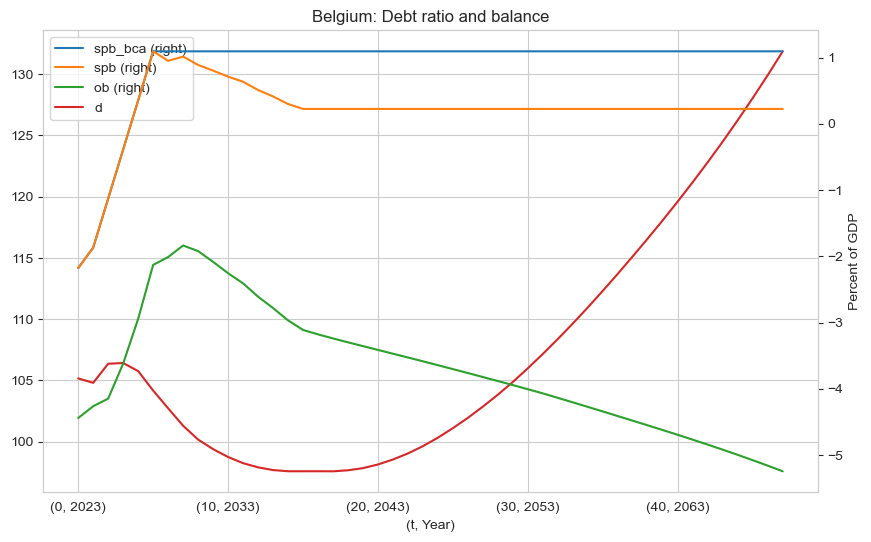

In [26]:
bel_dsa4.df('spb_bca', 'spb',  'ob', 'd').plot(
    title='Belgium: Debt ratio and balance', 
    secondary_y=['spb', 'spb_bca', 'ob'], 
    ylabel='Percent of GDP', 
    xlabel='(t, Year)', 
    legend=True, 
    figsize=(10, 6))

### Stochastic Optimization

The StochasticDsaModel class is a subclass of the DsaModel and inherits all its functionalities. It is initiated analogously.

The latest update introuces a number of addiitonal parameters that can be altered to test model assumptions. These include:
- "ageing_cost_period" to specify the post-adjustment window during which ageing costs are seperated out from SPB 
- "shock_frequency" to specify the underlying shock data frequenct as "quarterly" or annual"
- "shock_sample_start" for the start of the sampled shock data
- "stochastic_start_year" for the start of the fanchart, ie the period form which unceirtainty is incorporated into projections

In [43]:
esp_sdsa7 = StochasticDsaModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [44]:
esp_sdsa7.project()
esp_sdsa7.simulate(N=100000)

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio. If the save_df option is specified, we can access the underlying percentile data as new model attribute. The period parameter determines the number of projection periods. The Commission methodology uses 5.

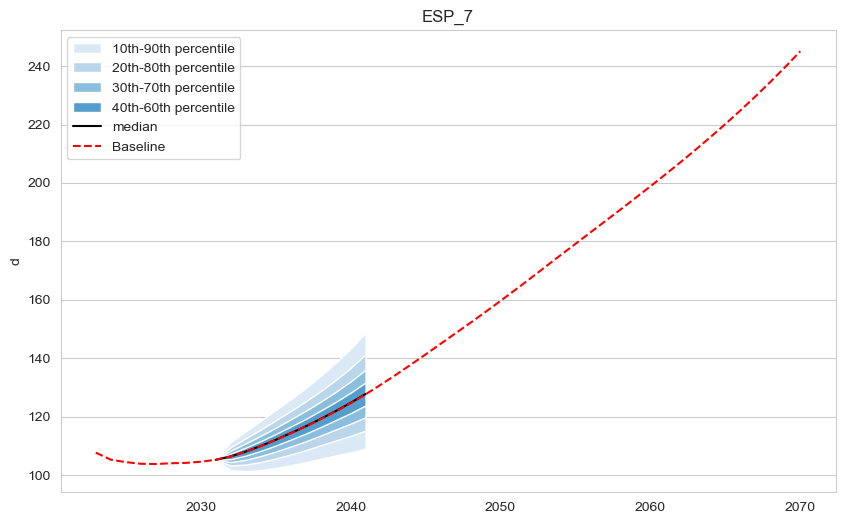

In [45]:
esp_sdsa7.fanchart(variable='d', periods=10)

In [46]:
esp_sdsa7.df_fanchart.dropna()

,year,baseline,p10,p20,p30,p40,p50,p60,p70,p80,p90
8,2031,105.183,105.183,105.183,105.183,105.183,105.183,105.183,105.183,105.183,105.183
9,2032,106.343,101.624,103.234,104.412,105.415,106.350,107.307,108.316,109.522,111.192
10,2033,107.944,101.256,103.547,105.200,106.614,107.976,109.333,110.780,112.517,114.949
11,2034,109.873,101.645,104.426,106.461,108.218,109.905,111.563,113.385,115.549,118.574
12,2035,111.988,102.401,105.612,107.992,110.057,112.006,113.991,116.151,118.683,122.219
13,2036,114.241,103.294,107.003,109.709,112.073,114.312,116.552,119.020,121.881,125.912
14,2037,116.587,104.362,108.462,111.506,114.133,116.622,119.152,121.946,125.191,129.692
15,2038,119.106,105.522,110.149,113.490,116.405,119.187,122.025,125.075,128.708,133.917
16,2039,121.767,106.691,111.787,115.529,118.763,121.844,124.976,128.415,132.524,138.380
17,2040,124.518,107.757,113.365,117.567,121.168,124.688,128.167,132.028,136.605,143.266


The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing. The probability target and the period over whcih the fanchart and the criterion are applied can be changed from their default values.

In [47]:
esp_sdsa7.find_spb_stochastic(prob_target=0.3, stochastic_criterion_period=5)

1.9022105538272736

### Integrated optimization

To quickly calculate all scenarios and detmerine which is binding, we can call the "find_spb_binding" method. Note that this method is only available after initalizing a stochastic model. \
The method determines optimal SPB targets for all deterministic and stochastic DSA criteria, as well as for the 3% deficit criteria. If no spcified differently, the method then checks whether the EDP or either of the two safeguards, the debt and the deficit resilience safeguard, are violated and corrects the binding SPB target accordingly.

In [48]:
esp_sdsa7.find_spb_binding(
    save_df=True, 
    edp=True, 
    debt_safeguard=True, 
    deficit_resilience=True, 
    deficit_resilience_post_adjustment=True
    )


________________________ Optimizing ESP 7-year ________________________
SPB*: 2.7778999999998115 (adverse_r_g)
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 1.419425546943073


'Binding SPB target: 2.7778999999998115 (adverse_r_g)'

The "find_spb_binding" method saves a dictionaries with the binding targets and timeseries for all scenarios. In addition, it saves the projection parameters of the binding scenario for quick replication.

In [49]:
esp_sdsa7.spb_target_dict

{'main_adjustment': 2.10979999999983,
 'lower_spb': 2.6006999999998004,
 'financial_stress': 2.148999999999827,
 'adverse_r_g': 2.7778999999998115,
 'deficit_reduction': 2.2566999999998205,
 'stochastic': 1.901660528129993,
 'post_adjustment': 1.419425546943073,
 'binding': 2.7778999999998115}

In [50]:
esp_sdsa7.df_dict['binding'].head()

,,d,spb_bca,spb_bca_adjustment,spb,pb,ob,sb,ageing_component,cyclical_component,interest_ratio,...,D,D_lt_esm,D_st,D_lt,repayment,repayment_lt,repayment_lt_esm,interest,interest_lt,interest_st
t,y,,,,,,,,,,,,,,,,,,,,,
0,2023,107.652,-1.631,NaN,-1.631,-1.176,-3.636,NaN,0.000,0.455,NaN,...,"1,573.800",-0.000,89.822,"1,483.978",NaN,NaN,4.575,NaN,NaN,NaN
1,2024,105.229,-0.849,0.782,-0.849,-0.265,-2.788,-3.372,0.000,0.584,2.523,...,"1,623.720",-4.575,92.671,"1,531.049",221.170,131.348,4.575,38.895,35.964,2.931
2,2025,104.512,-0.331,0.518,-0.331,0.019,-2.542,-2.892,0.000,0.350,2.561,...,"1,679.602",-8.218,95.861,"1,583.742",227.484,134.813,3.643,41.068,37.872,3.196
3,2026,103.558,0.187,0.518,0.187,0.189,-2.487,-2.488,0.000,0.001,2.675,...,"1,720.840",-11.861,98.214,"1,622.626",235.577,139.716,3.643,44.365,41.074,3.291
4,2027,102.516,0.705,0.518,0.705,0.435,-2.323,-2.053,0.000,-0.270,2.758,...,"1,760.644",-11.861,100.486,"1,660.158",238.028,139.813,0.000,47.265,43.908,3.357


In [51]:
esp_sdsa7.binding_parameter_dict

{'adjustment_steps': array([0.51812857, 0.51812857, 0.51812857, 0.51812857, 0.51812857,
        0.51812857, 0.51812857]),
 'spb_target': 2.7778999999998115,
 'criterion': 'adverse_r_g',
 'edp_binding': False,
 'edp_steps': array([nan, nan, nan, nan, nan, nan, nan]),
 'deficit_resilience_steps': array([nan, nan, nan, nan, nan, nan, nan]),
 'post_adjustment_steps': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.028, 0.18 , 0.171, 0.142,
        0.173, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ])}

The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
We can either call it directly by specifying an adjustment path or call it after we have optimized the path as above.

Text(0.5, 1.0, 'Spain: Probability of deficit during 7-year adjustment')

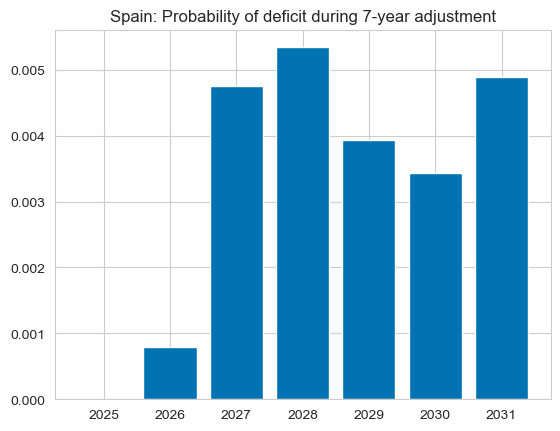

In [65]:
prob_deficit = esp_sdsa7.find_deficit_prob()
plt.bar(np.arange(2025, 2032), prob_deficit)
plt.title('Spain: Probability of deficit during 7-year adjustment')

Finally, we can use the model features to simulate consecutive adjustment periods and gain insight into which criteria would be bindin in future applications of the fiscal rules. The function "run_multiple_periods" performs an initial optimization for a given adjustment period, saves the net expenditure path, and optimizes the next period, taking the first period's path as given. 


________________________ Optimizing FRA 7-year ________________________
SPB*: 0.795399999999832 (adverse_r_g)
EDP not binding
Debt safeguard not binding
SPB* after deficit resilience: 0.817399999999832
SPB post-adjustment: 1.9215163701135771

________________________ Optimizing FRA 11-year ________________________
SPB*: 0.825599999999832 (adverse_r_g)
EDP not binding
SPB* after binding debt safeguard: 3.083599999999796
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 3.0903184264636585

________________________ Optimizing FRA 15-year ________________________
SPB*: 0.9707999999998331 (adverse_r_g)
EDP not binding
Debt safeguard not binding
SPB* after deficit resilience: 1.751799999999834
SPB post-adjustment: 1.7406113807197394


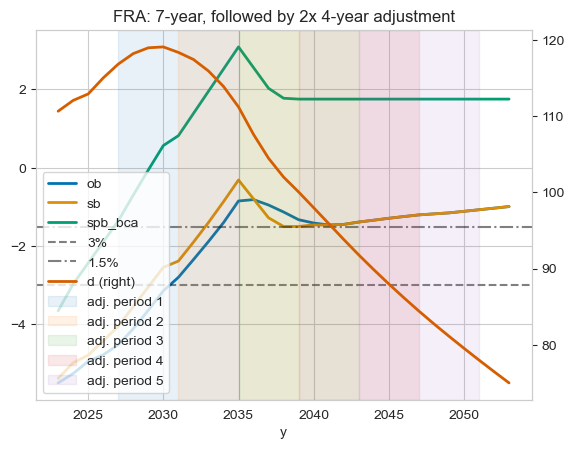

,main_adjustment,lower_spb,financial_stress,adverse_r_g,deficit_reduction,stochastic,deficit_resilience,deficit_resilience_post_adjustment,deficit_resilience_post_adjustment_bca,binding,debt_safeguard
adjustment_period_1,-0.023,0.533,0.383,0.795,0.753,0.626,0.817,1.922,2.026,0.817,NaN
adjustment_period_2,-0.051,0.414,0.413,0.826,0.660,0.424,NaN,3.090,3.084,3.084,3.084
adjustment_period_3,0.186,0.694,0.240,0.971,0.397,0.511,1.752,1.741,1.752,1.752,NaN


In [2]:
run_consecutive_dsa(
        country = 'FRA',
        start_year=2024, 
        initial_adjustment_period=7, 
        consecutive_adjustment_period=4, 
        number_of_adjustment_periods=3, 
        plot_results=True)

### Running the DSA for all countries

The functions in the functions folder contian preset loops that run the DSA for all countries, save and plot results. Simply run the "main.ipynb".